In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BID Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 18s 509ms/step - loss: 0.0458 - val_loss: 0.0542
Epoch 2/100
13/13 [==============================] - 3s 272ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 3/100
13/13 [==============================] - 3s 253ms/step - loss: 0.0061 - val_loss: 0.0111
Epoch 4/100
13/13 [==============================] - 6s 426ms/step - loss: 0.0053 - val_loss: 0.0135
Epoch 5/100
13/13 [==============================] - 4s 292ms/step - loss: 0.0043 - val_loss: 0.0118
Epoch 6/100
13/13 [==============================] - 5s 371ms/step - loss: 0.0039 - val_loss: 0.0077
Epoch 7/100
13/13 [==============================] - 4s 282ms/step - loss: 0.0034 - val_loss: 0.0073
Epoch 8/100
13/13 [==============================] - 5s 357ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 9/100
13/13 [==============================] - 4s 290ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 10/100
13/13 [==============================] - 5s 356ms/step - loss: 0.0027 - val_l

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 15ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 849.6449799969866
Testing RMSE: 1034.8805973076173


In [14]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.014581673432985477
Testing MAPE: 0.020977956064672842


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=74
i=0
while(i<30):
    
    if(len(temp_input)>74):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.9023416]
75
1 day input [0.68277043 0.68585033 0.69201013 0.68893023 0.68585033 0.67661063
 0.67969053 0.69201013 0.69201013 0.68585033 0.72280911 0.78132719
 0.72280911 0.67969053 0.7597679  0.7474483  0.74590835 0.77362744
 0.7536081  0.7628478  0.76130785 0.76746765 0.77824729 0.86756435
 0.8752641  0.87988395 0.90606309 0.86294451 0.86140456 0.87988395
 0.80904628 0.81982592 0.82598572 0.87680405 0.83984527 0.86140456
 0.84600506 0.81366613 0.85832466 0.82752567 0.84600506 0.87680405
 0.90144324 0.94456182 0.91530278 0.87680405 0.89374349 0.86448446
 0.85370481 0.84908496 0.89682339 0.91992263 0.90452314 0.90144324
 0.93532213 0.96920101 0.95842137 0.94302187 0.91530278 0.878344
 0.93224223 0.91530278 0.91684273 0.8875837  0.8875837  0.91068294
 0.90452314 0.89374349 0.90760304 0.90760304 0.91376284 0.91376284
 0.91376284 0.9023416 ]
1 day output [[0.89290786]]
2 day input [0.68585033 0.69201013 0.68893023 0.68585033 0.67661063 0.67969053
 0.69201013 0.69201013 0.68585033 0.7228

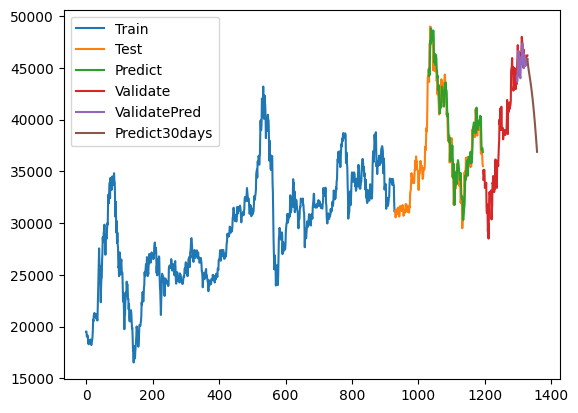

In [16]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [17]:
scaler.inverse_transform(lst_output)

array([[45829.16861119],
       [45522.86807485],
       [45230.5634789 ],
       [44981.93233248],
       [44756.17425293],
       [44541.68143458],
       [44332.58804568],
       [44124.2242571 ],
       [43912.83562686],
       [43695.54245927],
       [43470.16950032],
       [43235.01176887],
       [42988.75327495],
       [42730.44379641],
       [42459.4485616 ],
       [42175.39793216],
       [41878.10612128],
       [41567.55571144],
       [41243.8434666 ],
       [40907.13582081],
       [40557.63597838],
       [40195.58584924],
       [39821.22347275],
       [39434.85655833],
       [39036.78120373],
       [38627.41349401],
       [38207.2198315 ],
       [37776.82918199],
       [37337.07565089],
       [36889.04686521]])